![alexnet.png](https://github.com/kevinkevin556/Dlchemist/blob/main/images/alexnet_banner.png?raw=true)

<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an implementaiton-from-scratch of AlexNet, as introduced in the paper "ImageNet Classification with Deep Convolutional Neural Networks". ([original paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)) 

AlexNet is a convolutional neural network that was name after one of its inventor Alex Krizhevsky. In 2012, Alexnet won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) and astonishingly increased the classification accuracy by 10% comparing with the former champion. Since then, the CNN architecture has dominated the field of computer vision. Thus it is considered a milestone of deep learning. In addition, AlexNet has had a significant influence on the development of subsequent neural network architectures and has inspired many other successful models, such as VGGNet, GoogLeNet, and ResNet.



![Image Classification on ImageNet](https://i.imgur.com/cj8ckAG.png)

# **Section 1. Set up**

In [ ]:
!pip install einops

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.4 MB/s eta 0:00:00


### *Dataset and DataLoader*

In the paper of AlexNet, the author implement 3 data augmentation tricks:
* Crop a 256 x 256 image into 224 x 224 randomly
* Flip a image horizontally at random
* PCA color augmentation

PCA involves matrix inversion which is computation-costly, so we want to prevent calculating matrix inversion each time we load our data in. That's why even though `torchvision` provides a convenient function for CIFAR-10 dataset, I manually created a dataset class. I would like to compute PCA only once for the training data.

In [ ]:
from torch.utils.data import Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, RandomHorizontalFlip, RandomCrop
from einops import rearrange
from sklearn.decomposition import PCA

class CIFAR10Dataset(Dataset):
  def __init__(
      self,
      root = "./data",
      train = False,
      download = True,
      transform = None,
      target_transform  = None,
      pca_noise = 0,
      index=None
  ):
    if index is None:
      self.data = CIFAR10(root, train, ToTensor(),  None, download)
    else:
      self.data = Subset(CIFAR10(root, train, ToTensor(),  None, download), index)

    self.transform = transform
    self.target_transform = target_transform
    self.pca_noise = pca_noise
    if pca_noise > 0:
      self.eigvec, self.eigval = self.pca_augmentation()
      
  def pca_augmentation(self):
    n = len(self.data)
    eigvec = np.empty((n, 3, 3))
    eigval = np.empty((n, 3))
    pca = PCA()

    for i in tqdm(range(n), desc="Eigen-decomposing"):
      image = rearrange(self.data[i][0], 'c h w -> (h w) c').numpy()
      pca.fit(image)
      eigvec[i] = pca.components_.T
      eigval[i] = pca.explained_variance_
    
    eigvec = torch.from_numpy(eigvec).type(torch.float32)
    eigval = torch.from_numpy(eigval).type(torch.float32)
    return eigvec, eigval

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx][0]
    label = self.data[idx][1]
    
    if self.transform is not None:
      image = self.transform(image)
    if self.target_transform is not None:
      label = self.target_transform(label)

    if self.pca_noise > 0:
      eigvec, eigval = self.eigvec[idx], self.eigval[idx]
      alpha = torch.randn(3) * self.pca_noise
      jitter = (eigvec @ (alpha*eigval)).reshape(3, 1, 1)
      image = torch.clip(image+jitter, 0, 1)

    return image, label

Since AlexNet requires 224 x 224 images as inputs, I upsampled those images from 32 x 32 to conform to the architecture of AlexNet. However, this is generally not a smart practice, as it simply increases the computational complexity without adding information.

In [ ]:
augmentation = Compose([Resize(256), RandomHorizontalFlip(0.5), RandomCrop(224)])
transform = Compose([Resize(224)])

# Generate indices to permute the training data and conduct train-test-split
total_size = 50000
valid_size = total_size//5
indices = torch.randperm(total_size, generator=torch.Generator().manual_seed(42))

train_dataset = CIFAR10Dataset(
    train = True,
    pca_noise = 1, 
    transform = augmentation,
    index = indices[:-valid_size]
)

valid_dataset = CIFAR10Dataset(
    train = True, 
    pca_noise = 0, 
    transform = transform, 
    index = indices[-valid_size:]
)

test_dataset = CIFAR10Dataset(train=False, pca_noise=0, transform=transform)


print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Eigen-decomposing: 100%|██████████| 40000/40000 [00:28<00:00, 1380.74it/s]


Files already downloaded and verified
Files already downloaded and verified

Data Size:
* Training set   =>  40000 images
* Validation set =>  10000 images
* Testing set    =>  10000 images

Image Shape (C, H, W):
* Training image: torch.Size([3, 224, 224])
* Testing image:  torch.Size([3, 224, 224])


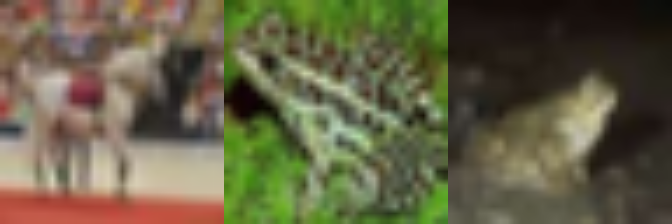

In [ ]:
# Raw Image

n_view = 3
sample_images = [valid_dataset[i][0] for i in range(n_view)]
sample_targets = [valid_dataset[i][1] for i in range(n_view)]
display(ToPILImage()(torch.dstack(sample_images)))
print(sample_targets)

Here we show the images being transformed from the training set. PCA augmentation did change the brightness of image, but it was not pretty obvious.

[7, 6, 6]


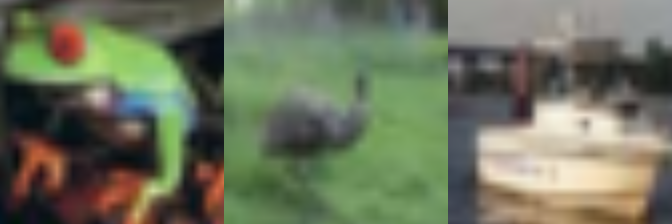

[6, 2, 8]


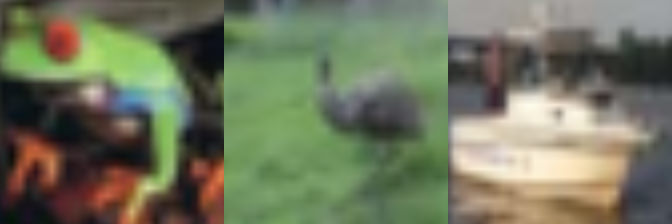

[6, 2, 8]


In [ ]:
# Image transformed

n_view = 3
sample_images = [train_dataset[i][0] for i in range(n_view)]
sample_targets = [train_dataset[i][1] for i in range(n_view)]
display(ToPILImage()(torch.dstack(sample_images)))
print(sample_targets)

sample_images = [train_dataset[i][0] for i in range(n_view)]
sample_targets = [train_dataset[i][1] for i in range(n_view)]
display(ToPILImage()(torch.dstack(sample_images)))
print(sample_targets)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

### *Network Architecture*

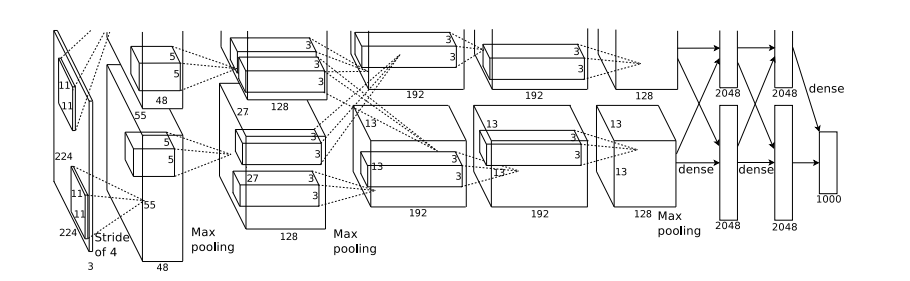

There are several features in the architeture of AlexNet.

**ReLU Nonlinearity** 

ReLU-based deep convolutional networks converges faster than the network using tanh and sigmoid activation. It is because tanh and sigmoid function lead to vanishing gradient problem. Namely, for the weights near input layers, both tanh and sigmoid activations will deminish their influence on loss as the newtork goes deeper, which make them difficult to be updated through back-propogation.

**Local Response Normalization**

The author found local response normalization (LRN) helps to achieve lower testing error when they trained on Imagenet and CIFAR-10. However, the paper of VGG falsify the claim. That's probabilly why you can see many Alexnet implementation without LRN. We do LRN to be faithful to the AlexNet architecture. 

**Overlapping Pooling**

Pooling layers in CNNs summarize the outputs of neighboring groups of neurons in the same kernel map. They observed that models with overlapping pooling was more difficult to overfit during training. However, again in the paper of VGG, the author of VGG thought pooling without overlapping was more effective.

In many sota practice, we basically use non-overlapping pooling in networks. 

**Dropout**

To apply dropout, we randomly remove some neurons in hidden layers during training. It is also a technique that effectively prevents overfitting.

In [ ]:
from torch.nn import  (
    Conv2d, ReLU,       MaxPool2d,  Flatten,
    Linear, Sequential, Dropout, LocalResponseNorm
)

class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = Sequential()
    self.net.add_module("Conv1", Sequential(
          Conv2d(in_channels=3, out_channels=48*2, kernel_size=11, stride=4),
          ReLU(),
          LocalResponseNorm(size=5, alpha=10e-4, beta=0.75, k=2),
          MaxPool2d(kernel_size=3, stride=2)
    ))
    self.net.add_module("Conv2", Sequential(
          Conv2d(in_channels=48*2, out_channels=128*2, kernel_size=5, padding=2),
          ReLU(),
          LocalResponseNorm(size=5, alpha=10e-4, beta=0.75, k=2),
          MaxPool2d(kernel_size=3, stride=2)
    ))
    self.net.add_module("Conv3", Sequential(  
        Conv2d(in_channels=128*2, out_channels=192*2, kernel_size=3, padding=1),
        ReLU()
    ))
    self.net.add_module("Conv4", Sequential(
        Conv2d(in_channels=192*2, out_channels=192*2, kernel_size=3, padding=1),
        ReLU()
    ))
    self.net.add_module("Conv5", Sequential(
        Conv2d(in_channels=192*2, out_channels=128*2, kernel_size=3, padding=1),
        ReLU(),
        MaxPool2d(kernel_size=3, stride=2)
    ))

    self.net.add_module("_", Flatten())

    self.net.add_module("FullyConnected6-8", Sequential(
        Linear(in_features=256*5*5, out_features=2048*2),
        Dropout(p=0.5),
        Linear(in_features=2048*2, out_features=4096*2),
        Dropout(p=0.5),
        Linear(in_features=4096*2, out_features=num_classes)
    ))

  def forward(self, x):
    return self.net(x)

print(AlexNet())

AlexNet(
  (net): Sequential(
    (Conv1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (Conv2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (Conv3): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (Conv4): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (Conv5): Sequential(
      (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dil

In [ ]:
# Check forward path
X = torch.randn(1, 3, 224, 224)
for layer in AlexNet().net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Sequential output shape:	 torch.Size([1, 10])


### *Test / Validation Step*

In [ ]:
def validate(model, dataloader, device=torch.device('cuda')):
  model.eval()
  acc = []

  with torch.no_grad():
    for images, targets in dataloader:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      pred_labels = torch.argmax(preds, dim=1)
      acc.append((pred_labels == targets).type(torch.float32) .mean().item())
  
  return acc

### *Training Step*

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    valid_dataloader,
    num_epochs = 1,
    device = torch.device('cuda'),
    state_dict = None
):
  
  best_valid_acc = 0
  
  if state_dict is not None:
    model.load_state_dict(state_dict)

  for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    train_progress = tqdm(train_dataloader, position=0, leave=True)

    ## Train
    for images, targets in train_progress:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      loss = criterion(preds, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_value = loss.detach().item()
      batch_losses.append(loss_value)
      train_progress.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
      train_progress.set_postfix({'loss': loss_value})
    
    ## Validate and save the best model (if any)
    valid_acc = validate(model,  valid_dataloader)
    print(f"Train Loss: {np.mean(batch_losses):.3f}, Valid Acc:{np.mean(valid_acc):.3f}")
    if np.mean(valid_acc) > best_valid_acc:
      best_valid_acc = np.mean(valid_acc)
      torch.save(model.state_dict(), "model_state_dict.ckpt")

# **Section 2. Start Training**

### *Optimization Configuration and First Training Stage*

In [ ]:
alexnet = AlexNet(num_classes=10)
alexnet.to(device)

optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

train(alexnet, criterion, optimizer, train_dataloader, valid_dataloader, num_epochs=60)

Epoch [1/60]: 100%|██████████| 313/313 [02:19<00:00,  2.24it/s, loss=2.17]


Train Loss: 2.296, Valid Acc:0.166


Epoch [2/60]: 100%|██████████| 313/313 [02:10<00:00,  2.39it/s, loss=1.97]


Train Loss: 2.058, Valid Acc:0.291


Epoch [3/60]: 100%|██████████| 313/313 [02:11<00:00,  2.39it/s, loss=1.6]


Train Loss: 1.807, Valid Acc:0.405


Epoch [4/60]: 100%|██████████| 313/313 [02:11<00:00,  2.37it/s, loss=1.42]


Train Loss: 1.576, Valid Acc:0.480


Epoch [5/60]: 100%|██████████| 313/313 [02:10<00:00,  2.40it/s, loss=1.37]


Train Loss: 1.404, Valid Acc:0.530


Epoch [6/60]: 100%|██████████| 313/313 [02:10<00:00,  2.40it/s, loss=1.34]


Train Loss: 1.261, Valid Acc:0.592


Epoch [7/60]: 100%|██████████| 313/313 [02:10<00:00,  2.39it/s, loss=1.3]


Train Loss: 1.132, Valid Acc:0.632


Epoch [8/60]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.935]


Train Loss: 1.029, Valid Acc:0.686


Epoch [9/60]: 100%|██████████| 313/313 [02:10<00:00,  2.40it/s, loss=1.43]


Train Loss: 0.928, Valid Acc:0.685


Epoch [10/60]: 100%|██████████| 313/313 [02:09<00:00,  2.42it/s, loss=0.599]


Train Loss: 0.846, Valid Acc:0.736


Epoch [11/60]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.642]


Train Loss: 0.774, Valid Acc:0.745


Epoch [12/60]: 100%|██████████| 313/313 [02:09<00:00,  2.42it/s, loss=0.862]


Train Loss: 0.721, Valid Acc:0.757


Epoch [13/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.7]


Train Loss: 0.673, Valid Acc:0.772


Epoch [14/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.386]


Train Loss: 0.627, Valid Acc:0.776


Epoch [15/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.675]


Train Loss: 0.600, Valid Acc:0.790


Epoch [16/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.48]


Train Loss: 0.562, Valid Acc:0.801


Epoch [17/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.662]


Train Loss: 0.530, Valid Acc:0.800


Epoch [18/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.512]


Train Loss: 0.505, Valid Acc:0.802


Epoch [19/60]: 100%|██████████| 313/313 [02:11<00:00,  2.37it/s, loss=0.297]


Train Loss: 0.477, Valid Acc:0.814


Epoch [20/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.471]


Train Loss: 0.444, Valid Acc:0.793


Epoch [21/60]: 100%|██████████| 313/313 [02:09<00:00,  2.42it/s, loss=0.409]


Train Loss: 0.427, Valid Acc:0.808


Epoch [22/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.354]


Train Loss: 0.403, Valid Acc:0.818


Epoch [23/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.302]


Train Loss: 0.387, Valid Acc:0.830


Epoch [24/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.327]


Train Loss: 0.369, Valid Acc:0.827


Epoch [25/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.623]


Train Loss: 0.351, Valid Acc:0.827


Epoch [26/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.435]


Train Loss: 0.339, Valid Acc:0.829


Epoch [27/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.463]


Train Loss: 0.330, Valid Acc:0.838


Epoch [28/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.45]


Train Loss: 0.311, Valid Acc:0.833


Epoch [29/60]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.16]


Train Loss: 0.295, Valid Acc:0.824


Epoch [30/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.41]


Train Loss: 0.277, Valid Acc:0.835


Epoch [31/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.229]


Train Loss: 0.268, Valid Acc:0.831


Epoch [32/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.354]


Train Loss: 0.254, Valid Acc:0.830


Epoch [33/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.246]


Train Loss: 0.244, Valid Acc:0.829


Epoch [34/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.227]


Train Loss: 0.244, Valid Acc:0.843


Epoch [35/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.27]


Train Loss: 0.229, Valid Acc:0.838


Epoch [36/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.312]


Train Loss: 0.217, Valid Acc:0.837


Epoch [37/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.113]


Train Loss: 0.208, Valid Acc:0.848


Epoch [38/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.329]


Train Loss: 0.207, Valid Acc:0.828


Epoch [39/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.267]


Train Loss: 0.197, Valid Acc:0.829


Epoch [40/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.293]


Train Loss: 0.200, Valid Acc:0.855


Epoch [41/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.0895]


Train Loss: 0.184, Valid Acc:0.838


Epoch [42/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.161]


Train Loss: 0.179, Valid Acc:0.847


Epoch [43/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.216]


Train Loss: 0.174, Valid Acc:0.831


Epoch [44/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.321]


Train Loss: 0.170, Valid Acc:0.849


Epoch [45/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.256]


Train Loss: 0.165, Valid Acc:0.843


Epoch [46/60]: 100%|██████████| 313/313 [02:11<00:00,  2.38it/s, loss=0.173]


Train Loss: 0.160, Valid Acc:0.853


Epoch [47/60]: 100%|██████████| 313/313 [02:10<00:00,  2.40it/s, loss=0.269]


Train Loss: 0.154, Valid Acc:0.846


Epoch [48/60]: 100%|██████████| 313/313 [02:11<00:00,  2.38it/s, loss=0.177]


Train Loss: 0.150, Valid Acc:0.845


Epoch [49/60]: 100%|██████████| 313/313 [02:11<00:00,  2.38it/s, loss=0.0585]


Train Loss: 0.151, Valid Acc:0.845


Epoch [50/60]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.268]


Train Loss: 0.138, Valid Acc:0.845


Epoch [51/60]: 100%|██████████| 313/313 [02:10<00:00,  2.40it/s, loss=0.136]


Train Loss: 0.131, Valid Acc:0.849


Epoch [52/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.151]


Train Loss: 0.129, Valid Acc:0.845


Epoch [53/60]: 100%|██████████| 313/313 [02:09<00:00,  2.43it/s, loss=0.143]


Train Loss: 0.131, Valid Acc:0.851


Epoch [54/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.166]


Train Loss: 0.128, Valid Acc:0.834


Epoch [55/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.0598]


Train Loss: 0.127, Valid Acc:0.837


Epoch [56/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.0536]


Train Loss: 0.123, Valid Acc:0.849


Epoch [57/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.0626]


Train Loss: 0.113, Valid Acc:0.840


Epoch [58/60]: 100%|██████████| 313/313 [02:09<00:00,  2.43it/s, loss=0.0375]


Train Loss: 0.115, Valid Acc:0.855


Epoch [59/60]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.141]


Train Loss: 0.117, Valid Acc:0.847


Epoch [60/60]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.0836]


Train Loss: 0.113, Valid Acc:0.845


It takes around 2 hours to complete training.

### *First Testing Stage*

In [ ]:
test_model = AlexNet(num_classes=10)
test_model.to(device)
best_state_dict = torch.load("model_state_dict.ckpt")
test_model.load_state_dict(best_state_dict)
print("Final Acc:", np.mean(validate(test_model, test_dataloader)))

Final Acc: 0.8453322784810127


### *Second Training Stage*

Let's run 10 more epochs to see if the network can achieve higher classification accuracy.

In [ ]:
train(alexnet, criterion, optimizer, train_dataloader, valid_dataloader, num_epochs=10)

Epoch [1/10]: 100%|██████████| 313/313 [02:10<00:00,  2.40it/s, loss=0.176]


Train Loss: 0.107, Valid Acc:0.852


Epoch [2/10]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.118]


Train Loss: 0.107, Valid Acc:0.850


Epoch [3/10]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.121]


Train Loss: 0.101, Valid Acc:0.852


Epoch [4/10]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.137]


Train Loss: 0.104, Valid Acc:0.834


Epoch [5/10]: 100%|██████████| 313/313 [02:10<00:00,  2.41it/s, loss=0.0871]


Train Loss: 0.100, Valid Acc:0.854


Epoch [6/10]: 100%|██████████| 313/313 [02:10<00:00,  2.41it/s, loss=0.0598]


Train Loss: 0.099, Valid Acc:0.858


Epoch [7/10]: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s, loss=0.156]


Train Loss: 0.094, Valid Acc:0.853


Epoch [8/10]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.14]


Train Loss: 0.096, Valid Acc:0.849


Epoch [9/10]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.0314]


Train Loss: 0.097, Valid Acc:0.852


Epoch [10/10]: 100%|██████████| 313/313 [02:09<00:00,  2.43it/s, loss=0.107]


Train Loss: 0.089, Valid Acc:0.853


### *Second Testing Stage*

In [ ]:
test_model = AlexNet(num_classes=10)
test_model.to(device)
best_state_dict = torch.load("model_state_dict.ckpt")
test_model.load_state_dict(best_state_dict)
print("Final Acc:", np.mean(validate(test_model, test_dataloader)))

Final Acc: 0.8499802215189873


**Accuracy of 85% is pretty much in enough for AlexNet on CIFAR-10.**

There are several benchmarks for this implementation.
1. [AlexNet in PyTorch CIFAR10 Clas](https://www.kaggle.com/code/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy): 83%
2. [Sebastian Raschka's impelementation](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-alexnet-cifar10.ipynb): 72.11%
3. [Github repo pytorch-cifar10](https://github.com/soapisnotfat/pytorch-cifar10): 74.74%

### *Visualization of Confusion matrix*

Among all targets, cat and dog are 2 difficult classes for AlexNet to tell apart.

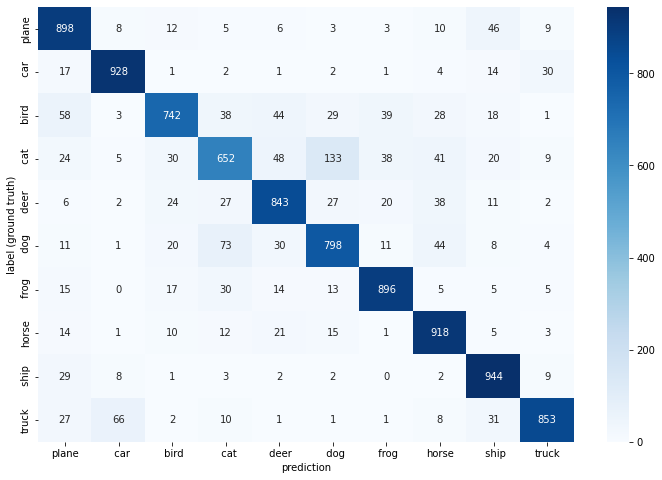

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np_pred_labels = []
np_targets = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images, targets = images.to(device), targets.to(device)
        preds = test_model(images)
        pred_labels = torch.argmax(preds, dim=1)
        
        pred_labels = pred_labels.view(-1).detach().cpu().numpy()
        targets = targets.view(-1).detach().cpu().numpy()

        np_pred_labels.append(pred_labels)
        np_targets.append(targets)

np_pred_labels = np. concatenate(np_pred_labels)
np_targets = np. concatenate(np_targets)
conf_mat = confusion_matrix(np_targets, np_pred_labels)

class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(conf_mat, class_names, class_names)
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show() 

Reference:
* [ImageNet Classification with Deep Convolutional Neural Networks](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
* [Dive into Deep Learning](http://d2l.ai/chapter_convolutional-modern/alexnet.html)
* [論文閱讀: AlexNet (ImageNet Classification with Deep Convolutional Neural Networks)](https://hackmd.io/@RinHizakura/HJfH2D5mI)